In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
#Para extraer los features del audio
def extract_feature(file_name):
  x, sample_rate = librosa.load(file_name)

  stft = np.abs(librosa.stft(x))

  result = np.array([])

  mfccs = np.mean(librosa.feature.mfcc(y=x, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mfccs))

  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis = 0)
  result = np.hstack((result, chroma))

  mel = np.mean(librosa.feature.melspectrogram(x, sr=sample_rate).T, axis = 0)
  result = np.hstack((result, mel))
  return result

In [ ]:
#Para cargar los datos del Drive Compartido
def load_data():
  x = []

  for file in glob.glob("/content/drive/Shareddrives/Reconocimiento de Voz Drive/Segmented/*.wav"):
    file_name = os.path.basename(file)
    feature = extract_feature(file)
    x.append(feature)

  return np.array(x)

In [ ]:
X = load_data()

In [72]:
#El primer numero nos muestra el numero de archivos que tenemos
#Y el segundo imprime el numbero de features/characteristicas que tiene los archivos
print(X.shape)

(2199, 160)


In [ ]:
#Normalizamos nuestros datos con funcion de estanderacion StandardScaler()
scaler = StandardScaler()
X_scl = scaler.fit_transform(X)
print(f'feature: {X_scl.shape[1]}')

feature: 160


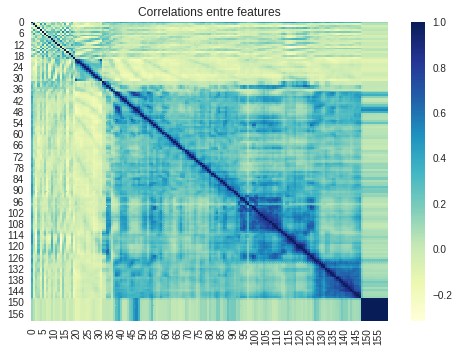

In [107]:
sns.heatmap(pd.DataFrame(X_scl).corr(), cmap="YlGnBu").set(title="Correlations entre features");

In [75]:
#Con la funcion PCA() obtenemos la relacion de la variancia explicado para luego poder sacer
#los features mas importantes
pca = PCA()
pca.fit(X_scl);

evr = pca.explained_variance_ratio_
evr

array([2.33763297e-01, 8.64373571e-02, 6.77046612e-02, 5.01187157e-02,
       3.99982449e-02, 3.09186586e-02, 2.81111985e-02, 2.61174802e-02,
       2.13877757e-02, 1.91458151e-02, 1.75185675e-02, 1.60722674e-02,
       1.51884910e-02, 1.43141580e-02, 1.32183590e-02, 1.29091985e-02,
       1.17921899e-02, 1.10461644e-02, 1.08294550e-02, 1.03197417e-02,
       9.74018901e-03, 9.26930709e-03, 9.05095109e-03, 8.22184480e-03,
       7.74249385e-03, 7.62359269e-03, 7.37283363e-03, 7.12189365e-03,
       6.74146376e-03, 6.54726363e-03, 6.15267148e-03, 6.07071609e-03,
       5.78144728e-03, 5.39736335e-03, 5.18486042e-03, 4.98774638e-03,
       4.87158140e-03, 4.80416889e-03, 4.63610766e-03, 4.45928793e-03,
       4.23194303e-03, 4.10289965e-03, 4.00860381e-03, 3.93147172e-03,
       3.75846132e-03, 3.72411188e-03, 3.44342158e-03, 3.29936583e-03,
       3.24010434e-03, 3.18597792e-03, 3.09462024e-03, 3.00039829e-03,
       2.87967931e-03, 2.74381041e-03, 2.70054788e-03, 2.63039634e-03,
      

In [90]:
#Con el metodo cumsum() valuamos cada feature su valor de relacion de la variancia explicado
#de tal forma filtrando los features mas importantes
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)
pca = PCA(n_components = n_comps)
pca.fit(X_scl)
scores_pca = pca.transform(X_scl)

Number of components: 28


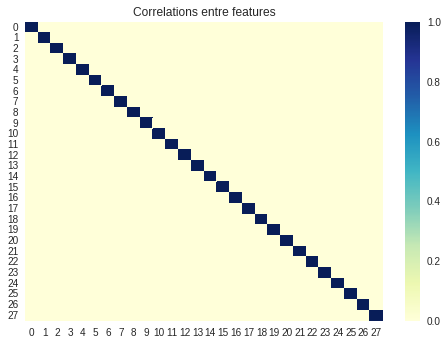

In [104]:
sns.heatmap(pd.DataFrame(scores_pca).corr(), cmap="YlGnBu").set(title="Correlations entre features");

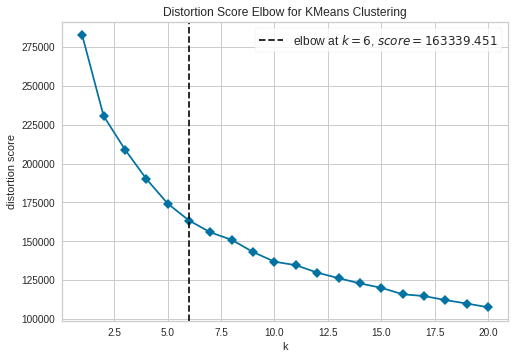

Optimal number of clusters: 6


In [66]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=42), k=(1,21), timings=False)
visualizer.fit(scores_pca)
visualizer.show()
n_clusters = visualizer.elbow_value_
print("Optimal number of clusters:", n_clusters)

In [111]:
kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=6, random_state=42)